# Project 1
## Imports, Dataset, Models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import time

# Device configuration
# I am using a Mac M3 chip, so I can't use CUDA, but if you are on nvidia, change this to CUDA
device = torch.device("mps")
device.type


'mps'

## Load the Dataset

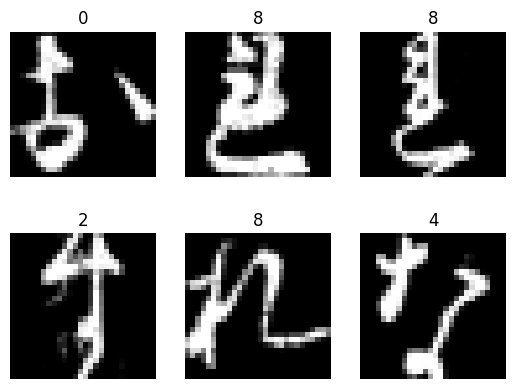

In [71]:
batch_size = 512

# KMNIST dataset
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Lambda(lambda x: x.flatten()),
    ]
).to(device)

transform_test = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Lambda(lambda x: x.flatten()),
    ]
).to(device)


train_dataset = torchvision.datasets.KMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.KMNIST(
    root="./data", train=False, download=True, transform=transform_test
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
)

# visualize some of the data
example_data, example_targets = next(iter(train_loader))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.title(example_targets[i].item())
    plt.axis("off")
    plt.imshow(example_data[i].reshape(28, 28), cmap="gray")

## Early Stopping

In [72]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(
        self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print
    ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        # Check if validation loss is nan
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            # Significant improvement detected
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset counter since improvement occurred
        else:
            # No significant improvement
            self.counter += 1
            if self.verbose:
                self.trace_func(
                    f"EarlyStopping counter: {self.counter} out of {self.patience}"
                )
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Stacked Autoencoder Class

In [73]:
class StackedAutoencoder(nn.Module):
    def __init__(self, bottleneck_size):
        super(StackedAutoencoder, self).__init__()
        self.bottleneck_size = bottleneck_size
        self.encoder = nn.Sequential(
            nn.Linear(784, 800),
            nn.ReLU(),
            nn.Linear(800, 200),
            nn.ReLU(),
            nn.Linear(200, self.bottleneck_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.bottleneck_size, 200),
            nn.ReLU(),
            nn.Linear(200, 800),
            nn.ReLU(),
            nn.Linear(800, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstruction = self.decoder(bottleneck)
        return reconstruction, bottleneck

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def fit(
        self,
        train_loader,
        optimizer,
        criterion,
        num_epochs,
        early_stopping=None,
        test_loader=None,
        with_penalty=False,
        verbose=True,
    ):
        start_time = time.time()
        for epoch in tqdm(range(num_epochs), disable=verbose):
            self.train()
            running_loss = 0.0
            running_test_loss = 0.0
            
            with tqdm(train_loader, unit="batch", disable=not verbose) as tepoch:
                if verbose:
                    tepoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")
                for images, labels in tepoch:
                    images = images.to(next(self.parameters()).device)
                    labels = labels.to(next(self.parameters()).device)
                    
                    optimizer.zero_grad()
                    reconstruction, bottleneck = self(images)
                    
                    loss = (
                        criterion(reconstruction, images, bottleneck, labels)
                        if with_penalty
                        else criterion(reconstruction, images)
                    )

                    running_loss += loss.item()
                    loss.backward()
                    optimizer.step()

                    batch_loss = running_loss / len(train_loader)
                    if verbose:
                        tepoch.set_postfix(loss=batch_loss)

                if early_stopping:
                    self.eval()
                    with torch.no_grad():
                        if test_loader is None:
                            raise ValueError("test_loader is required for early stopping")
                        for test_images, test_labels in test_loader:
                            test_images = test_images.to(next(self.parameters()).device)
                            test_labels = test_labels.to(next(self.parameters()).device)
                            reconstruction, bottleneck = self(test_images)
                            loss = (
                                criterion(reconstruction, test_images, bottleneck, test_labels)
                                if with_penalty
                                else criterion(reconstruction, test_images)
                            )
                            running_test_loss += loss.item()

                        test_loss = running_test_loss / len(test_loader)
                        early_stopping(test_loss, self)
                        if early_stopping.early_stop:
                            if verbose:
                                print("Early stopping!")
                            break
        end_time = time.time()
        elapsed_time = end_time - start_time
        return test_loss, elapsed_time
    
    def evaluate_classify_10(self, test_loader):
        self.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                reconstruction, bottleneck = self(images)
                # print the entire bottleneck max indices
                print(bottleneck[0].argmax())

                # Move tensors to CPU and convert to numpy arrays
                images = images.cpu().numpy().reshape(-1, 28, 28)

                # print the max index of the bottleneck
                reconstruction = reconstruction.cpu().numpy().reshape(-1, 28, 28)

                # Plot original and reconstructed images
                fig, axes = plt.subplots(2, 10, figsize=(15, 4))
                for i in range(10):
                    # Original images
                    axes[0, i].imshow(images[i].reshape(28, 28), cmap="gray")
                    axes[0, i].axis("off")
                    axes[0, i].set_title(f"orig: {labels[i]}")

                    # Reconstructed images
                    axes[1, i].imshow(reconstruction[i].reshape(28, 28), cmap="gray")
                    axes[1, i].axis("off")
                    axes[1, i].set_title(f"sae: {bottleneck.argmax(dim=1)[i]}")

                plt.show()
                break  # Only visualize the first batch

    def evaluate_classify(self, test_loader, verbose=False):
        self.eval()
        y_pred = []
        y_true = []

        self.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                _, bottleneck = self(images)
                bottleneck_labels = bottleneck.argmax(dim=1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(bottleneck_labels.cpu().numpy())
        accuracy = np.mean(np.array(y_true) == np.array(y_pred))

        if verbose:
            # Confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            cm_display = ConfusionMatrixDisplay(
                confusion_matrix=cm, display_labels=test_dataset.classes
            )
            cm_display.plot()
            plt.title(f"Confusion Matrix ({self.__class__.__name__})")
            plt.show()


            # Model summary of accuracy and hyperparameters
            print("Model Architecture:")
            print(self)
            print("\nModel Evaluation:")
            print(f"Accuracy: {accuracy:.2f}")
        

In [5]:
# hyperparams
sae_num_epochs = 100
sae_learning_rates = [0.001]
sae_bottleneck_sizes = [10]
sae_weight_decays = [1e-5]
verbose = False

print(sae_learning_rates)
print(sae_bottleneck_sizes)
print(sae_weight_decays)

# train the grid search, time the training and smallest validation loss, and the best hyperparameters
tracking = []

for sae_learning_rate in sae_learning_rates:
    for bottleneck_size in sae_bottleneck_sizes:
        for weight_decay in sae_weight_decays:
            print(
                f"Learning Rate: {sae_learning_rate}, Bottleneck Size: {bottleneck_size}, Weight Decay: {weight_decay}"
            )
            sae_model = StackedAutoencoder(bottleneck_size).to(device)
            sae_criterion = nn.MSELoss()
            path_model = f"models/sae_checkpoint_{sae_learning_rate}_{bottleneck_size}_{weight_decay}.pt"
            sae_early_stopping = EarlyStopping(
                patience=5, verbose=verbose, path=path_model
            )

            sae_optimizer = optim.RAdam(
                sae_model.parameters(),
                lr=sae_learning_rate,
                weight_decay=weight_decay,
            )

            test_loss, elapsed_time = sae_model.fit(
                train_loader,
                sae_optimizer,
                sae_criterion,
                sae_num_epochs,
                early_stopping=sae_early_stopping,
                test_loader=test_loader,
                verbose=verbose,
            )

            tracking.append(
                {
                    "learning_rate": sae_learning_rate,
                    "bottleneck_size": bottleneck_size,
                    "weight_decay": weight_decay,
                    "test_loss": test_loss,
                    "elapsed_time": elapsed_time,
                }
            )

            print(f"Test Loss: {test_loss:.6f}, Elapsed Time: {elapsed_time:.2f}s")

[0.001]
[10]
[1e-05]
Learning Rate: 0.001, Bottleneck Size: 10, Weight Decay: 1e-05


 51%|█████     | 51/100 [03:22<03:14,  3.97s/it]

Test Loss: 0.046057, Elapsed Time: 202.39s


In [6]:
best_score_idx = np.argmin([x["test_loss"] for x in tracking])
best_score = tracking[best_score_idx]["test_loss"]
best_elapsed_time_idx = np.argmin([x["elapsed_time"] for x in tracking])
best_elapsed_time = tracking[best_elapsed_time_idx]["elapsed_time"]

print(f"Best Score: {best_score:.6f}, Best Score Index: {best_score_idx}")
print(f"Best Elapsed Time: {best_elapsed_time:.2f}s, Best Elapsed Time Index: {best_elapsed_time_idx}")

Best Score: 0.046057, Best Score Index: 0
Best Elapsed Time: 202.39s, Best Elapsed Time Index: 0


tensor(5, device='mps:0')


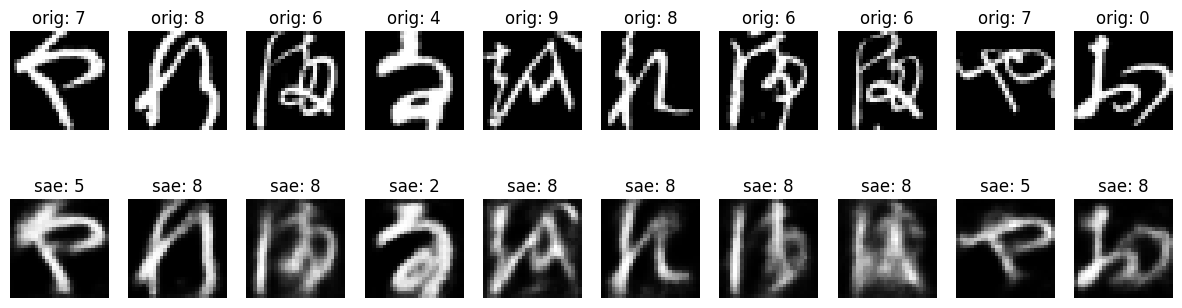

In [9]:
sae_model = StackedAutoencoder(tracking[best_score_idx]["bottleneck_size"]).to(device)
sae_model.load_state_dict(torch.load(f"models/sae_checkpoint_{sae_learning_rates[0]}_{sae_bottleneck_sizes[0]}_{sae_weight_decays[0]}.pt", weights_only=True))

sae_model.evaluate_classify_10(test_loader)

In [74]:
class MLPClassifier(nn.Module):
    def __init__(self, autoencoder):
        super(MLPClassifier, self).__init__()
        self.autoencoder = autoencoder
        bottleneck_size = autoencoder.bottleneck_size
        self.classifier = nn.Sequential(
            nn.Linear(bottleneck_size, bottleneck_size*10),
            nn.ReLU(),
            nn.Linear(bottleneck_size*10, bottleneck_size*20),
            nn.ReLU(),
            nn.Linear(bottleneck_size*20, bottleneck_size*10),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(bottleneck_size*10, bottleneck_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.classifier(x)

    def fit(
        self,
        train_loader,
        test_loader,
        optimizer,
        criterion,
        num_epochs,
        early_stopping,
        verbose=True,
    ):
        for epoch in tqdm(range(num_epochs)):
            self.train()
            self.autoencoder.eval()
            running_loss = 0.0
            with tqdm(train_loader, unit="batch", disable=not verbose) as tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")
                for images, labels in tepoch:
                    images = images.to(
                        next(self.parameters()).device, non_blocking=True
                    )
                    labels = labels.to(
                        next(self.parameters()).device, non_blocking=True
                    )
                    with torch.no_grad():
                        encoded_images = self.autoencoder.encode(images)
                    optimizer.zero_grad()
                    outputs = self(encoded_images)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()
                    loss.backward()
                    optimizer.step()
                    batch_loss = running_loss / len(train_loader)
                    tepoch.set_postfix(loss=batch_loss)

                self.eval()
                with torch.no_grad():
                    running_test_loss = 0.0
                    for test_images, test_labels in test_loader:
                        test_images = test_images.to(
                            next(self.parameters()).device, non_blocking=True
                        )
                        encoded_test_images = self.autoencoder.encode(test_images)
                        test_labels = test_labels.to(
                            next(self.parameters()).device, non_blocking=True
                        )
                        outputs = self(encoded_test_images)
                        loss = criterion(outputs, test_labels)
                        running_test_loss += loss.item()

                    test_loss = running_test_loss / len(test_loader)
                    early_stopping(test_loss, self)
                    if early_stopping.early_stop:
                        if verbose:
                            print("Early stopping!")
                        break

    def evaluate(self, test_loader, verbose=False):
        self.eval()
        y_pred = []
        y_true = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                encoded_images = self.autoencoder.encode(images)
                outputs = self(encoded_images)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

            if verbose:
                # Confusion matrix
                cm = confusion_matrix(y_true, y_pred)
                cm_display = ConfusionMatrixDisplay(
                    confusion_matrix=cm, display_labels=test_dataset.classes
                )
                cm_display.plot()
                plt.title(f"Confusion Matrix ({self.__class__.__name__})")
                plt.show()

                # Model summary of accuracy and hyperparameters
                print("Model Architecture:")
                print(self)
        
        
        accuracy = np.mean(np.array(y_true) == np.array(y_pred))
        
        if verbose:
            print("\nModel Evaluation:")
            print(f"Accuracy: {accuracy:.2f}")
        return accuracy

In [76]:
class MSELossWithPenalty(nn.Module):
    def __init__(self, num_classes, bottleneck_size, lambda_reg):
        """
        Custom loss function for SAE.

        Args:
        - targets (torch.Tensor): Target points for each class in the latent space (one-hot or predefined).
        - lambda_reg (float): Regularization strength.
        """
        super(MSELossWithPenalty, self).__init__()
        self.targets = torch.eye(num_classes, bottleneck_size)
        self.lambda_reg = lambda_reg

    def forward(self, reconstructed, original, codes, labels):
        """
        Computes the custom loss.

        Args:
        - reconstructed (torch.Tensor): Reconstructed inputs.
        - original (torch.Tensor): Original inputs.
        - codes (torch.Tensor): Latent codes from the encoder.
        - labels (torch.Tensor): Class labels for the inputs.

        Returns:
        - torch.Tensor: Total loss.
        """
        # Reconstruction Loss (MSE)
        reconstruction_loss = F.mse_loss(reconstructed, original)

        # Regularization Term (R)
        self.targets = self.targets.to(codes.device)
        batch_targets = self.targets[labels]
        #print("batch: ", batch_targets.shape, "codes: ", codes.shape)
        distances = torch.linalg.norm(codes - batch_targets, dim=1)
        regularization_term = distances.mean()

        # Total Loss
        total_loss = reconstruction_loss + self.lambda_reg * regularization_term
        return total_loss



[0.001]
[10]
[1e-05]
[0.25]
Learning Rate: 0.001, Bottleneck Size: 10, Weight Decay: 1e-05, Lambda Reg: 0.25


Epoch 1/100: 100%|██████████| 118/118 [00:03<00:00, 36.82batch/s, loss=0.328]


Validation loss decreased (inf --> 0.253196).  Saving model ...


Epoch 2/100: 100%|██████████| 118/118 [00:02<00:00, 39.56batch/s, loss=0.191]


Validation loss decreased (0.253196 --> 0.208819).  Saving model ...


Epoch 3/100: 100%|██████████| 118/118 [00:02<00:00, 39.94batch/s, loss=0.161]


Validation loss decreased (0.208819 --> 0.192380).  Saving model ...


Epoch 4/100: 100%|██████████| 118/118 [00:03<00:00, 38.59batch/s, loss=0.147]


Validation loss decreased (0.192380 --> 0.179882).  Saving model ...


Epoch 5/100: 100%|██████████| 118/118 [00:02<00:00, 39.37batch/s, loss=0.136]


Validation loss decreased (0.179882 --> 0.169244).  Saving model ...


Epoch 6/100: 100%|██████████| 118/118 [00:02<00:00, 39.62batch/s, loss=0.129]


Validation loss decreased (0.169244 --> 0.163390).  Saving model ...


Epoch 7/100: 100%|██████████| 118/118 [00:02<00:00, 40.06batch/s, loss=0.123]


Validation loss decreased (0.163390 --> 0.156916).  Saving model ...


Epoch 8/100: 100%|██████████| 118/118 [00:03<00:00, 38.52batch/s, loss=0.118]


Validation loss decreased (0.156916 --> 0.154020).  Saving model ...


Epoch 9/100: 100%|██████████| 118/118 [00:03<00:00, 39.28batch/s, loss=0.114] 


Validation loss decreased (0.154020 --> 0.149248).  Saving model ...


Epoch 10/100: 100%|██████████| 118/118 [00:02<00:00, 39.65batch/s, loss=0.11]  


Validation loss decreased (0.149248 --> 0.145884).  Saving model ...


Epoch 11/100: 100%|██████████| 118/118 [00:03<00:00, 37.92batch/s, loss=0.107] 


Validation loss decreased (0.145884 --> 0.143445).  Saving model ...


Epoch 12/100: 100%|██████████| 118/118 [00:02<00:00, 39.62batch/s, loss=0.104] 


Validation loss decreased (0.143445 --> 0.141711).  Saving model ...


Epoch 13/100: 100%|██████████| 118/118 [00:02<00:00, 39.36batch/s, loss=0.101] 


Validation loss decreased (0.141711 --> 0.140446).  Saving model ...


Epoch 14/100: 100%|██████████| 118/118 [00:03<00:00, 39.23batch/s, loss=0.0983]


Validation loss decreased (0.140446 --> 0.138286).  Saving model ...


Epoch 15/100: 100%|██████████| 118/118 [00:03<00:00, 38.78batch/s, loss=0.0963]


Validation loss decreased (0.138286 --> 0.135967).  Saving model ...


Epoch 16/100: 100%|██████████| 118/118 [00:03<00:00, 39.22batch/s, loss=0.0938]


Validation loss decreased (0.135967 --> 0.135650).  Saving model ...


Epoch 17/100: 100%|██████████| 118/118 [00:02<00:00, 39.43batch/s, loss=0.092] 


Validation loss decreased (0.135650 --> 0.133636).  Saving model ...


Epoch 18/100: 100%|██████████| 118/118 [00:03<00:00, 38.08batch/s, loss=0.0902]


Validation loss decreased (0.133636 --> 0.133554).  Saving model ...


Epoch 19/100: 100%|██████████| 118/118 [00:03<00:00, 39.14batch/s, loss=0.0885]


Validation loss decreased (0.133554 --> 0.131938).  Saving model ...


Epoch 20/100: 100%|██████████| 118/118 [00:02<00:00, 39.47batch/s, loss=0.087] 


Validation loss decreased (0.131938 --> 0.130743).  Saving model ...


Epoch 21/100: 100%|██████████| 118/118 [00:03<00:00, 38.05batch/s, loss=0.0856]


EarlyStopping counter: 1 out of 5


Epoch 22/100: 100%|██████████| 118/118 [00:03<00:00, 39.33batch/s, loss=0.0843]


Validation loss decreased (0.130743 --> 0.129730).  Saving model ...


Epoch 23/100: 100%|██████████| 118/118 [00:03<00:00, 38.75batch/s, loss=0.0829]


Validation loss decreased (0.129730 --> 0.128568).  Saving model ...


Epoch 24/100: 100%|██████████| 118/118 [00:03<00:00, 39.11batch/s, loss=0.0818]


Validation loss decreased (0.128568 --> 0.127794).  Saving model ...


Epoch 25/100: 100%|██████████| 118/118 [00:03<00:00, 38.12batch/s, loss=0.0805]


Validation loss decreased (0.127794 --> 0.127229).  Saving model ...


Epoch 26/100: 100%|██████████| 118/118 [00:03<00:00, 39.22batch/s, loss=0.0794]


Validation loss decreased (0.127229 --> 0.126534).  Saving model ...


Epoch 27/100: 100%|██████████| 118/118 [00:03<00:00, 39.04batch/s, loss=0.0783]


EarlyStopping counter: 1 out of 5


Epoch 28/100: 100%|██████████| 118/118 [00:03<00:00, 38.32batch/s, loss=0.0774]


Validation loss decreased (0.126534 --> 0.124866).  Saving model ...


Epoch 29/100: 100%|██████████| 118/118 [00:03<00:00, 38.91batch/s, loss=0.0764]


Validation loss decreased (0.124866 --> 0.124586).  Saving model ...


Epoch 30/100: 100%|██████████| 118/118 [00:03<00:00, 38.92batch/s, loss=0.0754]


Validation loss decreased (0.124586 --> 0.124121).  Saving model ...


Epoch 31/100: 100%|██████████| 118/118 [00:03<00:00, 38.70batch/s, loss=0.0746]


Validation loss decreased (0.124121 --> 0.122674).  Saving model ...


Epoch 32/100: 100%|██████████| 118/118 [00:03<00:00, 38.91batch/s, loss=0.0736]


EarlyStopping counter: 1 out of 5


Epoch 33/100: 100%|██████████| 118/118 [00:03<00:00, 38.86batch/s, loss=0.0729]


EarlyStopping counter: 2 out of 5


Epoch 34/100: 100%|██████████| 118/118 [00:03<00:00, 38.60batch/s, loss=0.072] 


Validation loss decreased (0.122674 --> 0.121641).  Saving model ...


Epoch 35/100: 100%|██████████| 118/118 [00:03<00:00, 37.67batch/s, loss=0.0712]


EarlyStopping counter: 1 out of 5


Epoch 36/100: 100%|██████████| 118/118 [00:03<00:00, 39.06batch/s, loss=0.0709]


Validation loss decreased (0.121641 --> 0.121304).  Saving model ...


Epoch 37/100: 100%|██████████| 118/118 [00:03<00:00, 38.40batch/s, loss=0.0701]


EarlyStopping counter: 1 out of 5


Epoch 38/100: 100%|██████████| 118/118 [00:03<00:00, 38.15batch/s, loss=0.0698]


Validation loss decreased (0.121304 --> 0.120581).  Saving model ...


Epoch 39/100: 100%|██████████| 118/118 [00:03<00:00, 38.72batch/s, loss=0.069] 


Validation loss decreased (0.120581 --> 0.120216).  Saving model ...


Epoch 40/100: 100%|██████████| 118/118 [00:03<00:00, 38.72batch/s, loss=0.0685]


Validation loss decreased (0.120216 --> 0.118928).  Saving model ...


Epoch 41/100: 100%|██████████| 118/118 [00:02<00:00, 39.46batch/s, loss=0.068] 


Validation loss decreased (0.118928 --> 0.118827).  Saving model ...


Epoch 42/100: 100%|██████████| 118/118 [00:03<00:00, 39.05batch/s, loss=0.0671]


EarlyStopping counter: 1 out of 5


Epoch 43/100: 100%|██████████| 118/118 [00:03<00:00, 38.04batch/s, loss=0.0668]


EarlyStopping counter: 2 out of 5


Epoch 44/100: 100%|██████████| 118/118 [00:03<00:00, 39.24batch/s, loss=0.0666]


Validation loss decreased (0.118827 --> 0.118128).  Saving model ...


Epoch 45/100: 100%|██████████| 118/118 [00:03<00:00, 38.18batch/s, loss=0.0659]


Validation loss decreased (0.118128 --> 0.118014).  Saving model ...


Epoch 46/100: 100%|██████████| 118/118 [00:03<00:00, 39.00batch/s, loss=0.0654]


Validation loss decreased (0.118014 --> 0.117941).  Saving model ...


Epoch 47/100: 100%|██████████| 118/118 [00:03<00:00, 39.26batch/s, loss=0.065] 


Validation loss decreased (0.117941 --> 0.117705).  Saving model ...


Epoch 48/100: 100%|██████████| 118/118 [00:03<00:00, 37.79batch/s, loss=0.0645]


EarlyStopping counter: 1 out of 5


Epoch 49/100: 100%|██████████| 118/118 [00:03<00:00, 37.13batch/s, loss=0.0641]


Validation loss decreased (0.117705 --> 0.117488).  Saving model ...


Epoch 50/100: 100%|██████████| 118/118 [00:03<00:00, 38.65batch/s, loss=0.0639]


EarlyStopping counter: 1 out of 5


Epoch 51/100: 100%|██████████| 118/118 [00:03<00:00, 38.83batch/s, loss=0.0634]


EarlyStopping counter: 2 out of 5


Epoch 52/100: 100%|██████████| 118/118 [00:03<00:00, 37.53batch/s, loss=0.0627]


Validation loss decreased (0.117488 --> 0.116493).  Saving model ...


Epoch 53/100: 100%|██████████| 118/118 [00:03<00:00, 38.61batch/s, loss=0.0623]


EarlyStopping counter: 1 out of 5


Epoch 54/100: 100%|██████████| 118/118 [00:03<00:00, 39.01batch/s, loss=0.062] 


Validation loss decreased (0.116493 --> 0.116288).  Saving model ...


Epoch 55/100: 100%|██████████| 118/118 [00:03<00:00, 37.44batch/s, loss=0.062] 


Validation loss decreased (0.116288 --> 0.116265).  Saving model ...


Epoch 56/100: 100%|██████████| 118/118 [00:03<00:00, 38.56batch/s, loss=0.0615]


EarlyStopping counter: 1 out of 5


Epoch 57/100: 100%|██████████| 118/118 [00:03<00:00, 38.71batch/s, loss=0.061] 


Validation loss decreased (0.116265 --> 0.115171).  Saving model ...


Epoch 58/100: 100%|██████████| 118/118 [00:03<00:00, 37.76batch/s, loss=0.0609]


Validation loss decreased (0.115171 --> 0.115030).  Saving model ...


Epoch 59/100: 100%|██████████| 118/118 [00:03<00:00, 38.20batch/s, loss=0.0603]


Validation loss decreased (0.115030 --> 0.114883).  Saving model ...


Epoch 60/100: 100%|██████████| 118/118 [00:03<00:00, 38.91batch/s, loss=0.0603]


Validation loss decreased (0.114883 --> 0.114428).  Saving model ...


Epoch 61/100: 100%|██████████| 118/118 [00:03<00:00, 38.95batch/s, loss=0.0595]


Validation loss decreased (0.114428 --> 0.113613).  Saving model ...


Epoch 62/100: 100%|██████████| 118/118 [00:03<00:00, 37.47batch/s, loss=0.0597]


EarlyStopping counter: 1 out of 5


Epoch 63/100: 100%|██████████| 118/118 [00:03<00:00, 38.65batch/s, loss=0.0594]


Validation loss decreased (0.113613 --> 0.112774).  Saving model ...


Epoch 64/100: 100%|██████████| 118/118 [00:03<00:00, 38.47batch/s, loss=0.0589]


EarlyStopping counter: 1 out of 5


Epoch 65/100: 100%|██████████| 118/118 [00:03<00:00, 37.84batch/s, loss=0.0584]


EarlyStopping counter: 2 out of 5


Epoch 66/100: 100%|██████████| 118/118 [00:03<00:00, 38.93batch/s, loss=0.0587]


EarlyStopping counter: 3 out of 5


Epoch 67/100: 100%|██████████| 118/118 [00:03<00:00, 38.51batch/s, loss=0.0585]


EarlyStopping counter: 4 out of 5


Epoch 68/100: 100%|██████████| 118/118 [00:03<00:00, 39.11batch/s, loss=0.0581]


EarlyStopping counter: 5 out of 5
Early stopping!
Test Loss: 0.112866, Elapsed Time: 235.25s


  1%|          | 1/100 [00:03<05:19,  3.23s/it]

Validation loss decreased (inf --> 2.172308).  Saving model ...


  2%|▏         | 2/100 [00:06<05:15,  3.22s/it]

Validation loss decreased (2.172308 --> 1.632723).  Saving model ...


  3%|▎         | 3/100 [00:09<05:13,  3.23s/it]

Validation loss decreased (1.632723 --> 1.572394).  Saving model ...


  4%|▍         | 4/100 [00:12<05:09,  3.23s/it]

Validation loss decreased (1.572394 --> 1.566275).  Saving model ...


  5%|▌         | 5/100 [00:16<05:05,  3.22s/it]

Validation loss decreased (1.566275 --> 1.565898).  Saving model ...


  6%|▌         | 6/100 [00:19<05:03,  3.23s/it]

Validation loss decreased (1.565898 --> 1.564946).  Saving model ...


  7%|▋         | 7/100 [00:22<04:59,  3.22s/it]

Validation loss decreased (1.564946 --> 1.561556).  Saving model ...


  8%|▊         | 8/100 [00:25<04:55,  3.21s/it]

EarlyStopping counter: 1 out of 5


  9%|▉         | 9/100 [00:28<04:52,  3.22s/it]

EarlyStopping counter: 2 out of 5


 10%|█         | 10/100 [00:32<04:48,  3.21s/it]

Validation loss decreased (1.561556 --> 1.558750).  Saving model ...


 11%|█         | 11/100 [00:35<04:46,  3.22s/it]

Validation loss decreased (1.558750 --> 1.557487).  Saving model ...


 12%|█▏        | 12/100 [00:38<04:44,  3.24s/it]

EarlyStopping counter: 1 out of 5


 13%|█▎        | 13/100 [00:41<04:40,  3.22s/it]

Validation loss decreased (1.557487 --> 1.556955).  Saving model ...


 14%|█▍        | 14/100 [00:45<04:36,  3.22s/it]

Validation loss decreased (1.556955 --> 1.555822).  Saving model ...


 15%|█▌        | 15/100 [00:48<04:34,  3.23s/it]

Validation loss decreased (1.555822 --> 1.555805).  Saving model ...


 16%|█▌        | 16/100 [00:51<04:30,  3.22s/it]

EarlyStopping counter: 1 out of 5


 17%|█▋        | 17/100 [00:54<04:26,  3.21s/it]

EarlyStopping counter: 2 out of 5


 18%|█▊        | 18/100 [00:57<04:24,  3.22s/it]

EarlyStopping counter: 3 out of 5


 19%|█▉        | 19/100 [01:01<04:20,  3.21s/it]

EarlyStopping counter: 4 out of 5


 20%|██        | 20/100 [01:04<04:17,  3.22s/it]

Validation loss decreased (1.555805 --> 1.554345).  Saving model ...


 21%|██        | 21/100 [01:07<04:17,  3.26s/it]

EarlyStopping counter: 1 out of 5


 22%|██▏       | 22/100 [01:11<04:14,  3.26s/it]

EarlyStopping counter: 2 out of 5


 23%|██▎       | 23/100 [01:14<04:11,  3.27s/it]

EarlyStopping counter: 3 out of 5


 24%|██▍       | 24/100 [01:17<04:11,  3.31s/it]

EarlyStopping counter: 4 out of 5


 24%|██▍       | 24/100 [01:20<04:16,  3.37s/it]

EarlyStopping counter: 5 out of 5
Early stopping!


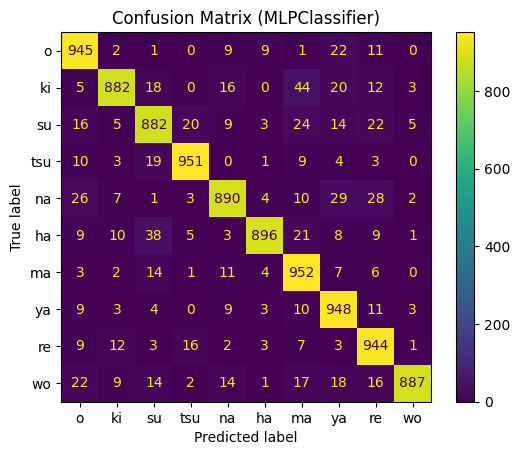

Model Architecture:
MLPClassifier(
  (autoencoder): StackedAutoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=800, bias=True)
      (1): ReLU()
      (2): Linear(in_features=800, out_features=200, bias=True)
      (3): ReLU()
      (4): Linear(in_features=200, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=800, bias=True)
      (3): ReLU()
      (4): Linear(in_features=800, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=100, out_features=10, bias=True)
    (8): Sigmoid()
  )

In [77]:
# hyperparams
sae_num_epochs = 100

sae_learning_rates = [0.001]
sae_bottleneck_sizes = [10]
sae_weight_decays = [1e-5]
sae_lambda_regs = [0.25]
verbose = True

print(sae_learning_rates)
print(sae_bottleneck_sizes)
print(sae_weight_decays)
print(sae_lambda_regs)

# train the grid search, time the training and smallest validation loss, and the best hyperparameters
tracking_w_penalty = []

for sae_learning_rate in sae_learning_rates:
    for bottleneck_size in sae_bottleneck_sizes:
        for weight_decay in sae_weight_decays:
            for lambda_reg in sae_lambda_regs:
                print(
                    f"Learning Rate: {sae_learning_rate}, Bottleneck Size: {bottleneck_size}, Weight Decay: {weight_decay}, Lambda Reg: {lambda_reg}"
                )
                sae_model = StackedAutoencoder(bottleneck_size).to(device)
                sae_criterion = MSELossWithPenalty(10, bottleneck_size, lambda_reg)
                path_model = f"models/sae_checkpoint_{sae_learning_rate}_{bottleneck_size}_{weight_decay}_{lambda_reg}.pt"
                sae_early_stopping = EarlyStopping(
                    patience=5, verbose=verbose, path=path_model
                )

                sae_optimizer = optim.RAdam(
                    sae_model.parameters(),
                    lr=sae_learning_rate,
                    weight_decay=weight_decay,
                    decoupled_weight_decay=True,
                )

                test_loss, elapsed_time = sae_model.fit(
                    train_loader,
                    sae_optimizer,
                    sae_criterion,
                    sae_num_epochs,
                    early_stopping=sae_early_stopping,
                    test_loader=test_loader,
                    with_penalty=True,
                    verbose=verbose,
                )

                print(f"Test Loss: {test_loss:.6f}, Elapsed Time: {elapsed_time:.2f}s")

                mlp_learning_rate = 0.001
                mlp_num_epochs = 100

                mlp_model = MLPClassifier(sae_model).to(device)
                mlp_criterion = nn.CrossEntropyLoss()
                mlp_optimizer = optim.RAdam(
                    
                    mlp_model.parameters(), lr=mlp_learning_rate, weight_decay=1e-5, decoupled_weight_decay=True
                )
                path_model = f"models/mlp_checkpoint_{sae_learning_rate}_{bottleneck_size}_{weight_decay}_{lambda_reg}.pt"
                mlp_early_stopping = EarlyStopping(patience=5, verbose=verbose, path=path_model)

                mlp_model.fit(
                    train_loader,
                    test_loader,
                    mlp_optimizer,
                    mlp_criterion,
                    mlp_num_epochs,
                    mlp_early_stopping,
                    verbose=verbose,
                )
                
                accuracy = mlp_model.evaluate(test_loader, verbose=verbose)

                tracking.append(
                    {
                        "learning_rate": sae_learning_rate,
                        "bottleneck_size": bottleneck_size,
                        "weight_decay": weight_decay,
                        "test_loss": test_loss,
                        "elapsed_time": elapsed_time,
                        "lambda_reg": lambda_reg,
                        "mlp_accuracy": accuracy,
                    }
                )

                print(f"Accuracy: {accuracy}\n")

In [ ]:
best_accuracy_idx = np.argmax([x["mlp_accuracy"] for x in tracking])

sae_model = StackedAutoencoder(10).to(device)
sae_model.load_state_dict(torch.load(f"models/sae_checkpoint_0.001_10_{tracking[best_accuracy_idx]['weight_decay']}_{tracking[best_accuracy_idx]['lambda_reg']}.pt", weights_only=True))
sae_model.evaluate_classify_10(test_loader)
sae_model.evaluate_classify(test_loader)

KeyError: 'mlp_accuracy'

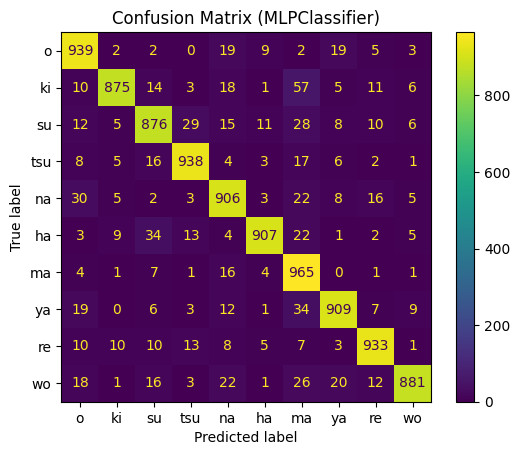

Model Architecture:
MLPClassifier(
  (autoencoder): StackedAutoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=800, bias=True)
      (1): ReLU()
      (2): Linear(in_features=800, out_features=200, bias=True)
      (3): ReLU()
      (4): Linear(in_features=200, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=800, bias=True)
      (3): ReLU()
      (4): Linear(in_features=800, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)

Model Evaluation:
Accuracy: 0.9129


In [66]:
mlp_model.evaluate(test_loader)